In [66]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [67]:
import numpy as np
import pandas as pd

In [99]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [69]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [70]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [71]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [72]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [73]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [74]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

- Design a query to retrieve the last 12 months of precipitation data and plot the results
- Calculate the date 1 year ago from the last data point in the database
- Perform a query to retrieve the data and precipitation scores
- Save the query results as a Pandas DataFrame and set the index to the date column
- Sort the dataframe by date
- Use Pandas Plotting with Matplotlib to plot the data

In [110]:
#Most recent date
date_query = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date = date_query[0]
recent_date = dt.datetime.strptime(recent_date,'%Y-%m-%d').date()
print(recent_date)

2017-08-23


In [112]:
#Calculate the date one year ago
past_date = recent_date - dt.timedelta(365)
print(past_date)

2016-08-23


In [147]:
#Retrieve data and precipitation scores
precip_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > past_date).order_by(Measurement.date).all()

In [148]:
#Create data frame
precip_df = pd.DataFrame(precip_data, columns = ['Date', 'Prcp'])

precip_df['Date'] = pd.to_datetime(precip_df['Date'], format='%Y/%m/%d')

#Reset the index to date
precip_df.set_index(precip_df['Date'], inplace=True)
precip_df.head()

,Date,Prcp
Date,,
2016-08-24,2016-08-24,0.08
2016-08-24,2016-08-24,2.15
2016-08-24,2016-08-24,2.28
2016-08-24,2016-08-24,NaN
2016-08-24,2016-08-24,1.22


Text(0,0.5,'Precipitation')

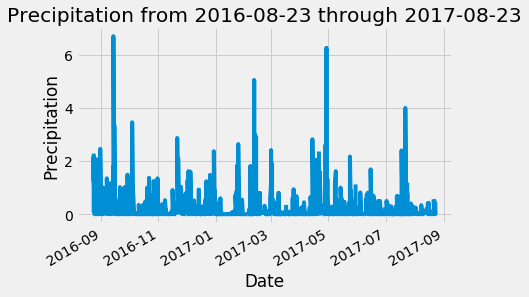

In [152]:
#Graph data
precip_df.plot('Date', 'Prcp', legend = False)
plt.title(f'Precipitation from {past_date} through {recent_date}')
plt.xlabel('Date')
plt.ylabel('Precipitation')

In [153]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [154]:
# Design a query to show how many stations are available in this dataset?
number_stations = session.query(Station.station).group_by(Station.station).count()
number_stations

9

In [155]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [156]:
most_active_station = active_stations[0][0]
most_active_station

'USC00519281'

In [157]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_data = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).filter(Measurement.date > past_date).\
    order_by(Measurement.date).all()
print(most_active_data)

[(59.0, 83.0, 73.0968660968661)]


In [158]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_temps = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).filter(Measurement.date > past_date).\
    order_by(Measurement.date).all()

Text(0.5,1,'Temperature Frequency at USC00519281')

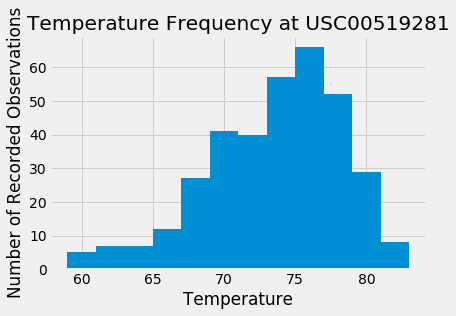

In [159]:
temp_df = pd.DataFrame(most_active_temps)
plt.hist(temp_df['tobs'], bins=12)
plt.xlabel('Temperature')
plt.ylabel('Number of Recorded Observations')
plt.title(f'Temperature Frequency at {most_active_station}')

In [160]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [161]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_trip = calc_temps('2017-02-10', '2017-02-17')
print(my_trip)

average_temp = my_trip[0][1]
min_temp = my_trip[0][0]
max_temp = my_trip[0][2]

[(62.0, 71.75, 80.0)]


Text(0,0.5,'Temperature')

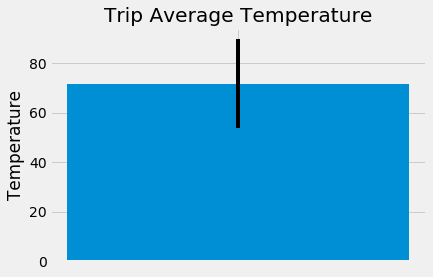

In [162]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.bar(1, average_temp, yerr = (max_temp-min_temp), tick_label = '')
plt.title('Trip Average Temperature')
plt.ylabel('Temperature')